# CIFAR-10 Dataset

In this notebook, we are going to train a CNN for image classification using the CIFAR-10 dataset. We will base our architecture choices using visualization techniques.

## Designing the model architecture 

First, we are going to build an inital architecture that we will analyze and modify accordingly.

In [1]:
import numpy as np
import random

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils import np_utils
from keras.optimizers import rmsprop

# Set random seed for reproducibility.
np.random.seed(0)
random.seed(0)

# Set hyperparameters.
batch_size = 32             # In each iteration, we consider 32 training examples at once.
num_epochs = 5              # We iterate 5 times over the entire training set.
kernel_size = 3             # We use 3x3 kernels throughout the convolutions.
pool_size = 2               # We use 2x2 pooling throughout the pooling layers.
conv_depth_1 = 32           # We initially have 32 kernels per conv. layer.
conv_depth_2 = 64           # Switching to 64 after the first pooling layer.
drop_prob_1 = 0.25          # Dropout after pooling with probability 0.25
drop_prob_2 = 0.5           # Dropout in the dense layer with probability 0.5
hidden_size = 128           # The dense layer will have 128 neurons

# Fetch CIFAR-10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Dataset information.
num_train, height, width, depth = x_train.shape # There are 50000 training examples in CIFAR-10.
num_test = x_test.shape[0]                      # There are 10000 test examples in CIFAR-10.
num_classes = np.unique(y_train).shape[0]       # There are 10 image classes.

# Normalise data to [0, 1] range.
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
x_train /= np.max(x_train)
x_test /= np.max(x_test)

# One-hot encode the labels.
y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
y_test = np_utils.to_categorical(y_test, num_classes)   # One-hot encode the labels

# Define layers of the first convolutional step.
conv_1 = Conv2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu', input_shape=(height, width, depth))
conv_2 = Conv2D(conv_depth_1, (kernel_size, kernel_size), activation='relu')
pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))
drop_1 = Dropout(drop_prob_1)

# Define layers of the second convolutional step.
conv_3 = Conv2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')
conv_4 = Conv2D(conv_depth_2, (kernel_size, kernel_size), activation='relu')
pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))
drop_2 = Dropout(drop_prob_1)

# Define layers of the classification step.
flat_1 = Flatten()
dens_1 = Dense(hidden_size, activation='relu')
drop_3 = Dropout(drop_prob_2)
output = Dense(num_classes, activation='softmax')

# Instantiate and train the model.
model = Sequential()
model.add(conv_1)
model.add(conv_2)
model.add(pool_1)
model.add(drop_1)
model.add(conv_3)
model.add(conv_4)
model.add(pool_2)
model.add(drop_2)
model.add(flat_1)
model.add(dens_1)
model.add(drop_3)
model.add(output)

opt = rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1, shuffle=True)

# Evaluate the model.
scores = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Using TensorFlow backend.


Train on 45000 samples, validate on 5000 samples
Epoch 1/5
45000/45000 [==============================] - 149s 3ms/step - loss: 1.9671 - acc: 0.2758 - val_loss: 1.6537 - val_acc: 0.4048
Epoch 2/5
45000/45000 [==============================] - 156s 3ms/step - loss: 1.6603 - acc: 0.3914 - val_loss: 1.4856 - val_acc: 0.4648
Epoch 3/5
45000/45000 [==============================] - 130s 3ms/step - loss: 1.5346 - acc: 0.4366 - val_loss: 1.4089 - val_acc: 0.4914
Epoch 4/5
45000/45000 [==============================] - 165s 4ms/step - loss: 1.4538 - acc: 0.4745 - val_loss: 1.4164 - val_acc: 0.4824
Epoch 5/5
45000/45000 [==============================] - 151s 3ms/step - loss: 1.3787 - acc: 0.5070 - val_loss: 1.2435 - val_acc: 0.5616
Accuracy: 55.44%


By plotting the confusion matrix of the classes in the dataset, we can have a better understanding of in which ways the model is underperforming.

In [2]:
y_pred = model.predict(x_test)

pred_labels = np.argmax(y_pred, axis=1)
true_labels = np.argmax(y_test, axis=1)

confusion_matrix = np.zeros((num_classes, num_classes))

for i in range(pred_labels.shape[0]):
    confusion_matrix[true_labels[i], pred_labels[i]] += 1

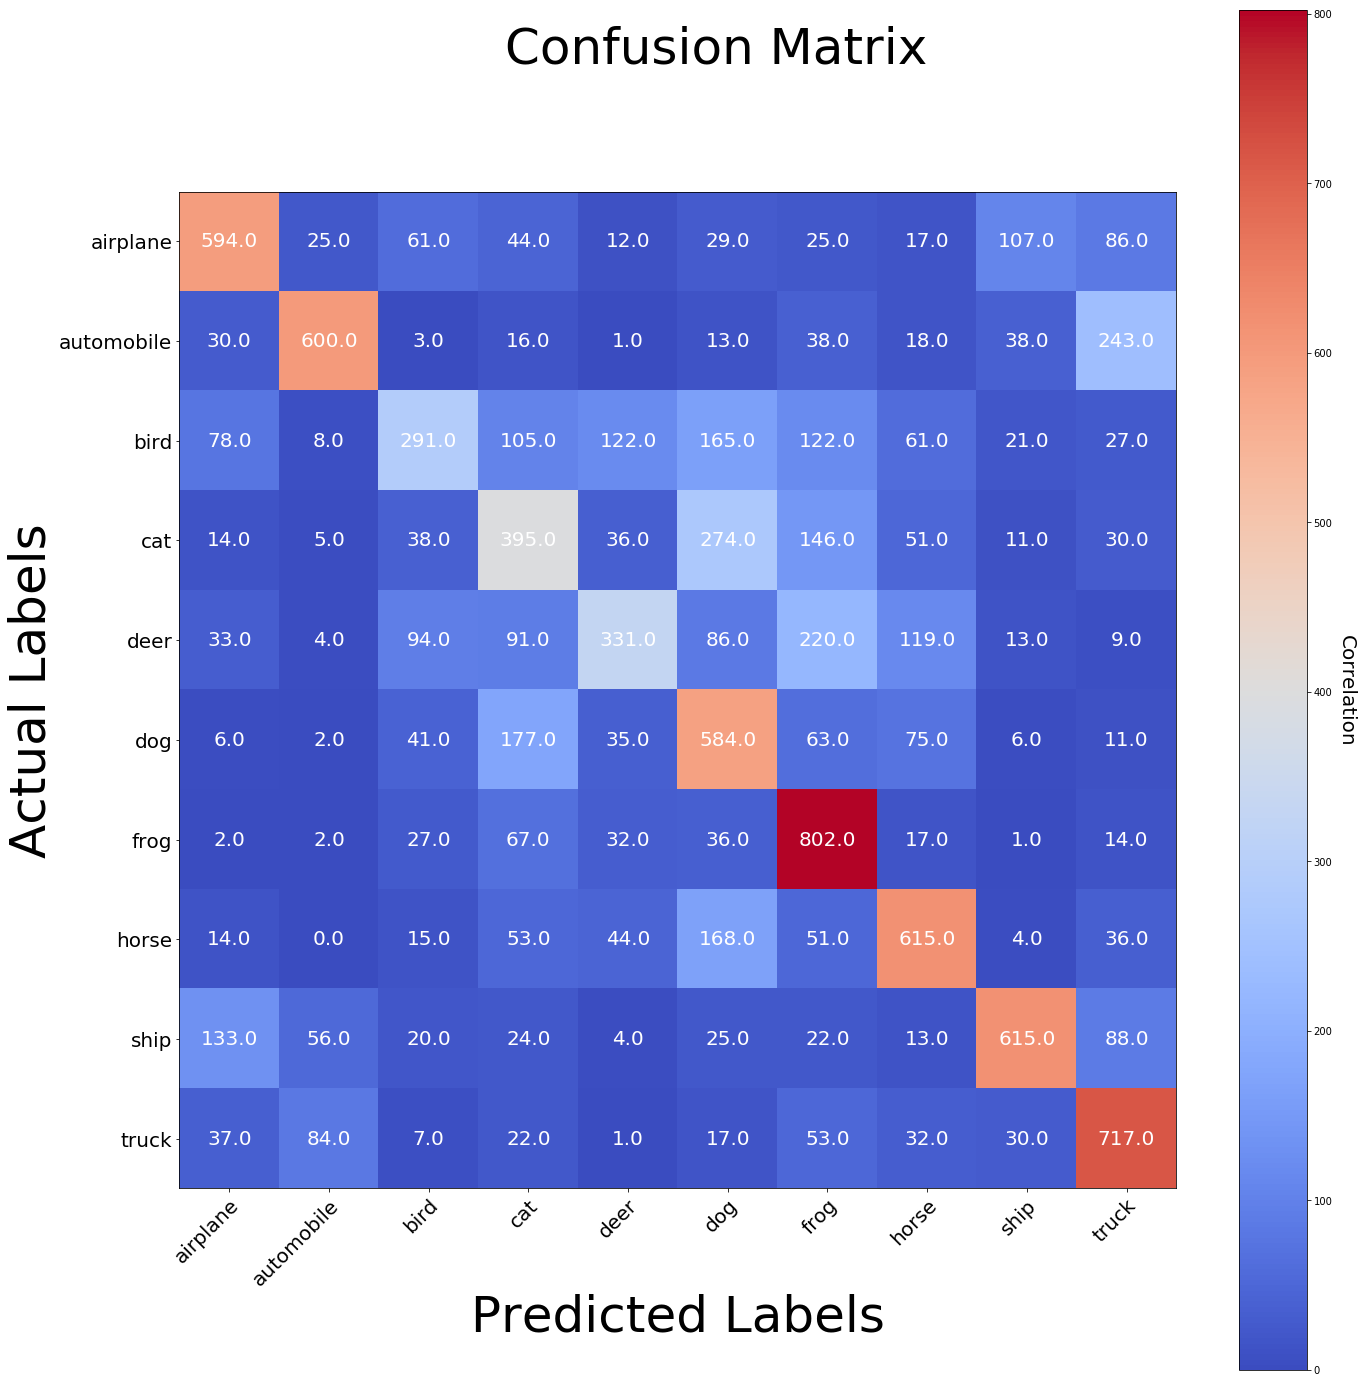

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
    
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(confusion_matrix, cmap=cm.coolwarm)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

ax.set_xticklabels(labels, fontdict={'fontsize': 20})
ax.set_yticklabels(labels, fontdict={'fontsize': 20})

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='w', fontdict={'fontsize': 20})

cbar = fig.colorbar(im)
cbar.ax.set_ylabel("Correlation", rotation=-90, va="bottom", fontdict={'fontsize': 20})

fig.suptitle('Confusion Matrix', fontsize=50)
plt.ylabel('Actual Labels', fontdict={'fontsize': 50})
plt.xlabel('Predicted Labels', fontdict={'fontsize': 50})

fig.tight_layout()
plt.show()

By looking at the confusion matrix, we recognize three clear underperforming classes:
        - Bird: often mistaken by dog, frog, or cat.
        - Cat: mainly mistaken by dog and, to a lesser extent, frog.
        - Deer: mainly mistaken by frog, but also by dog or horse to a lesser extent.

Another issues we can identify:
        - Automobiles have a strong confusion with Trucks. The opposite does not happens in the same proportion though.
        - Airplanes and ships have a reasonably high confusion in both directions.
        - Dogs are sometimes mistaken by cats.
        - Horses are sometimes mistaken by dogs.

One way to identify how this happens is to visualize the activation vectors produced in the last hidden layer. If they are too similar for elements of the different classes, it is likely they will be uncorrectly assigned to the same class.

In [8]:
# Create a partial model to retrieve activations from the dense layer.
model_ap = Sequential()
model_ap.add(conv_1)
model_ap.add(conv_2)
model_ap.add(pool_1)
model_ap.add(drop_1)
model_ap.add(conv_3)
model_ap.add(conv_4)
model_ap.add(pool_2)
model_ap.add(drop_2)
model_ap.add(flat_1)
model_ap.add(dens_1)

activations = model_ap.predict(x_test)

print(activations.shape)

(10000, 128)


Now we are going to project the activation vector of each test input to 2-D to look for similarities.

In [9]:
from sklearn.manifold import TSNE

actv_proj = TSNE(n_components=2, perplexity=20, early_exaggeration=12.0, learning_rate=200.0, verbose=1).fit(activations)
actv_proj_data = actv_proj.embedding_

print(actv_proj_data.shape, actv_proj.kl_divergence_)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.165s...
[t-SNE] Computed neighbors for 10000 samples in 29.175s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.628727
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.713089
[t-SNE] Error after 1000 iterations: 2.246435
(10000, 2) 2.2464349269866943


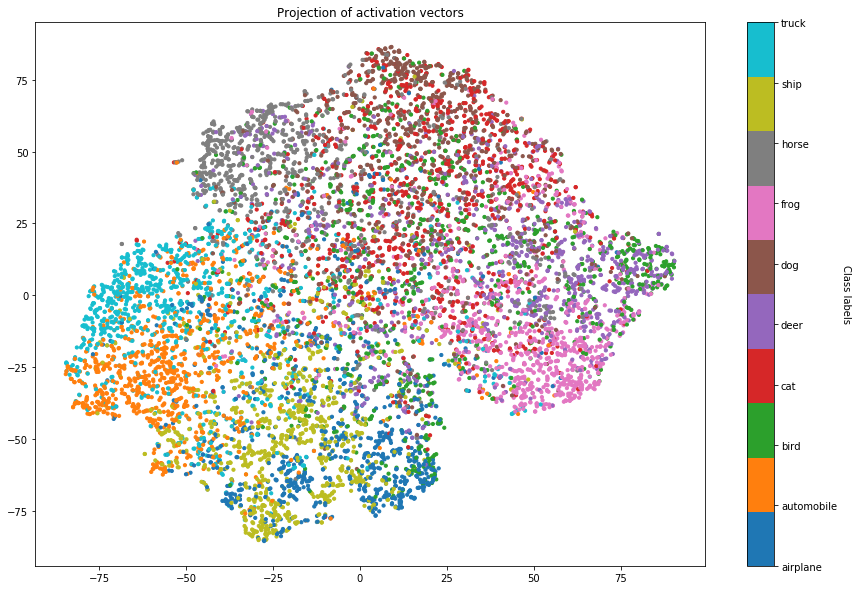

In [10]:
colors = true_labels

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection of activation vectors")

im = plt.scatter(actv_proj_data[:, 0], actv_proj_data[:, 1], c=colors, cmap=cm.tab10, s=10)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Class labels", rotation=-90, va="bottom")
cbar.ax.set_yticklabels(labels)

plt.show()

By looking at the projections, we can identify that, at several regions, we have samples of different classes producing very similar activations. In particular:
    - Activations from bird inputs are very spread, what confirms our findings that the model is confusing it with several labels.
    - Cats indeed occupy the same region of dogs, explaining the confusion. The cat/frog confusion is also noticeable.
    - Deer also shares the same region with frogs, although not all of it.
    - Airplane and ships overlay each other considerably.
    - Horses and dogs connection is not so visible.

By looking at the label histogram projection, we can identify which units are learning features from each class

In [11]:
from sklearn.cluster import AgglomerativeClustering

# Build the histograms.
histograms = np.zeros((hidden_size, num_classes))

for u in range(hidden_size):
    for c in range(num_classes):
        a = activations[true_labels == c, u]
        histograms[u, c] = np.sum(a)

# Normalize histograms.
histograms /= np.max(histograms)

# Sort the histogram rows
c = AgglomerativeClustering(n_clusters=histograms.shape[0]).fit(histograms)

merge_order = c.children_

index_list = [[i] for i in range(histograms.shape[0])]
for i, j in merge_order:
    index_list.append(index_list[i] + index_list[j])
order = index_list[-1]

histograms = histograms[order, :]
        
print(histograms.shape)

(128, 10)


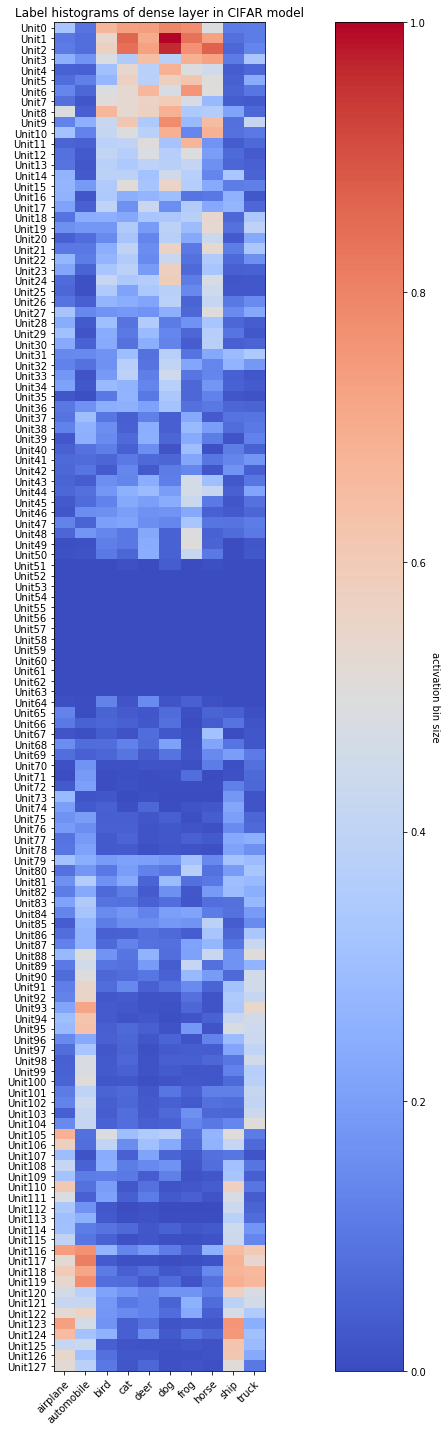

In [13]:
units = ["Unit" + str(i) for i in range(hidden_size)]

fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(histograms, aspect=0.5, cmap=cm.coolwarm)

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("activation bin size", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(units)))

ax.set_xticklabels(labels)
ax.set_yticklabels(units)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_title("Label histograms of dense layer in CIFAR model")

fig.tight_layout()
plt.show()

In [14]:
lh_projection = TSNE(n_components=2, perplexity=20, early_exaggeration=12.0, learning_rate=200.0).fit(histograms)

lhp_data = lh_projection.embedding_

print(lhp_data.shape, lh_projection.kl_divergence_)

(128, 2) 0.36418119072914124


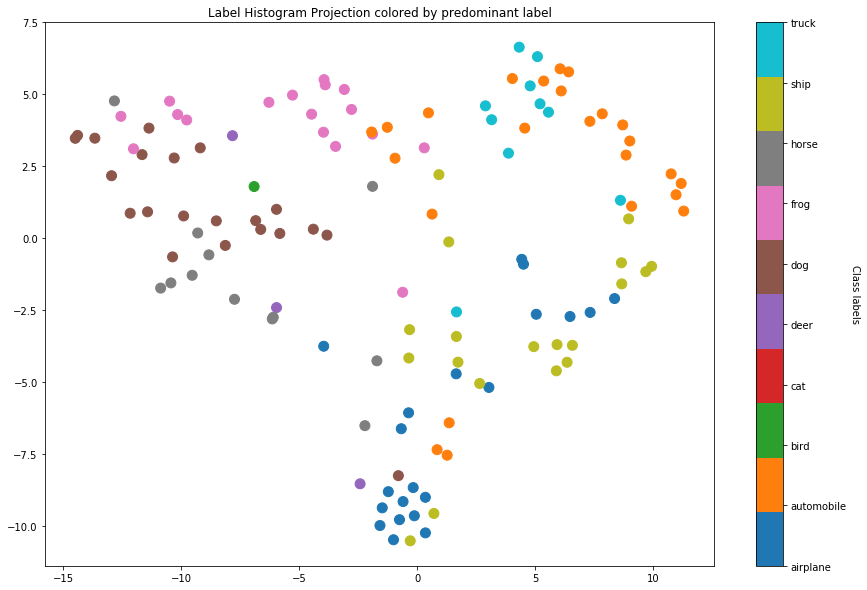

In [15]:
colors = np.argmax(histograms, axis=1)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Label Histogram Projection colored by predominant label")

im = plt.scatter(lhp_data[:, 0], lhp_data[:, 1], c=colors, cmap=cm.tab10, s=100)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Class labels", rotation=-90, va="bottom")
cbar.ax.set_yticklabels(labels)

plt.show()

[Text(1,0,'airplane'),
 Text(1,0,'automobile'),
 Text(1,0,'bird'),
 Text(1,0,'cat'),
 Text(1,0,'deer'),
 Text(1,0,'dog'),
 Text(1,0,'frog'),
 Text(1,0,'horse'),
 Text(1,0,'ship'),
 Text(1,0,'truck')]

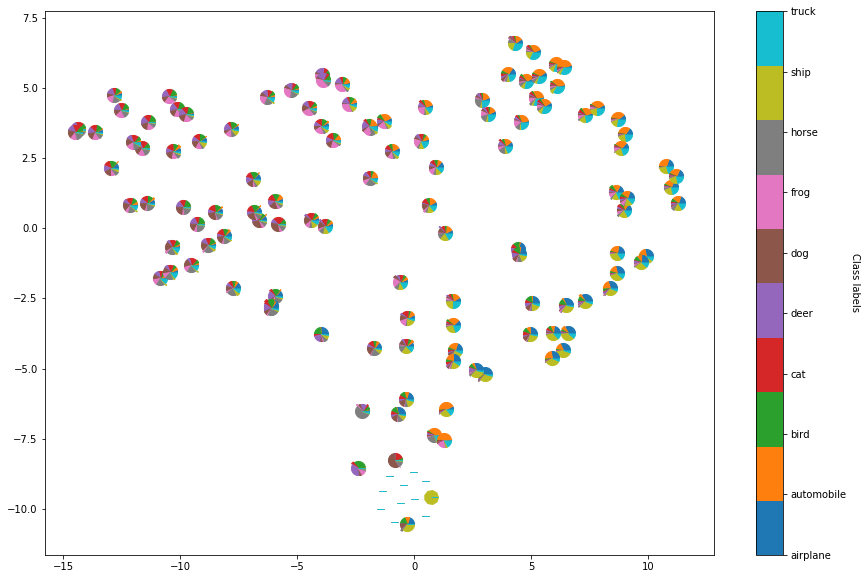

In [16]:
# Transform histogram data into pie chart.
h = np.array(histograms)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        h[i, :] /= t
    
    for j in range(1, h.shape[1]):
        h[i, j] += h[i, j-1]
        
fig, ax = plt.subplots(figsize=(15, 10))
        
# Plot piecharts.
for i in range(h.shape[0]):
    for j in range(h.shape[1]):
        if j == 0:
            a = 0
        else:
            a = 2*np.pi*h[i, j-1]
        
        b = 2*np.pi*h[i, j]
                
        x = [0] + np.cos(np.linspace(a, b, 10)).tolist()
        y = [0] + np.sin(np.linspace(a, b, 10)).tolist()
        xy = np.column_stack([x, y])
        
        ax.scatter(lhp_data[i, 0], lhp_data[i, 1], marker=(xy, 0), s=200, c=cm.tab10(j))

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Class labels", rotation=-90, va="bottom")
cbar.ax.set_yticklabels(labels)

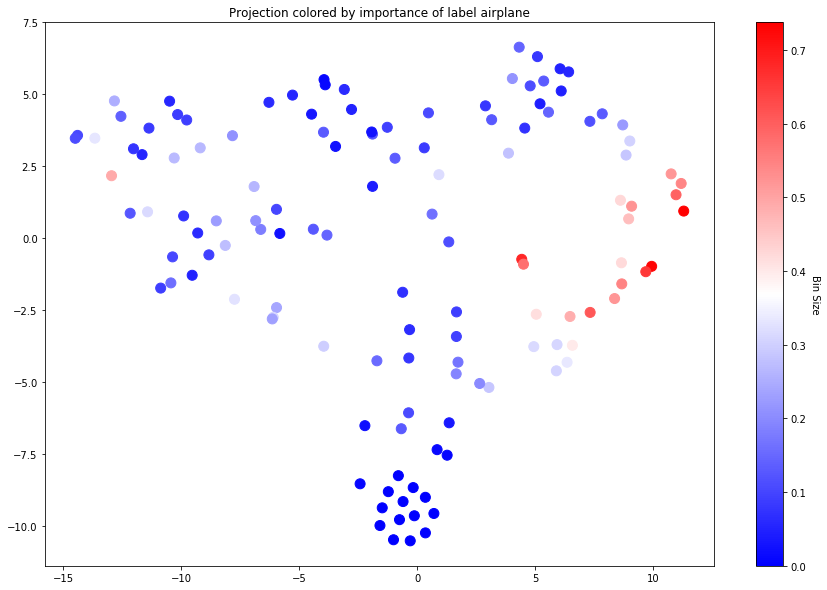

In [17]:
# Take into account only the importance of label 0.
l = 0
h = np.array(histograms)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l])
im = plt.scatter(lhp_data[:, 0], lhp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

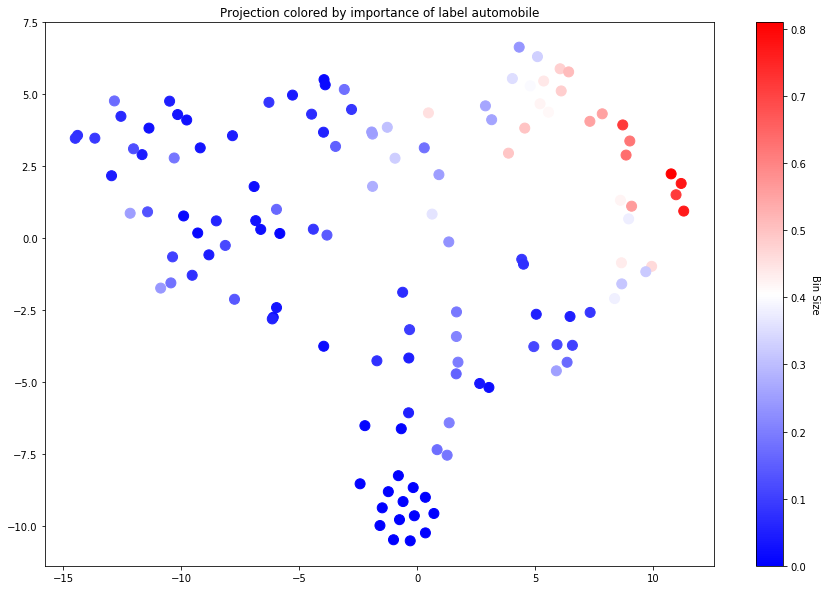

In [18]:
# Take into account only the importance of label 0.
l = 1
h = np.array(histograms)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l])
im = plt.scatter(lhp_data[:, 0], lhp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

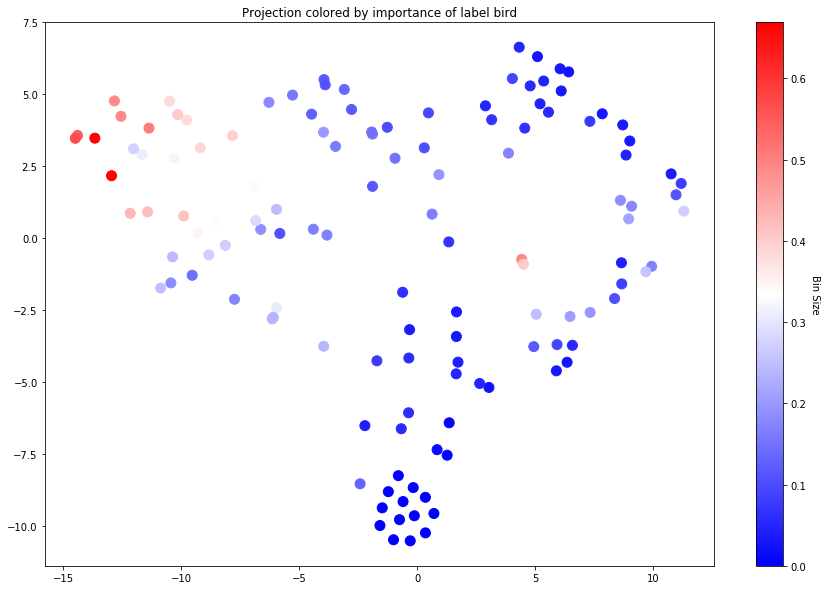

In [19]:
# Take into account only the importance of label 0.
l = 2
h = np.array(histograms)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l])
im = plt.scatter(lhp_data[:, 0], lhp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

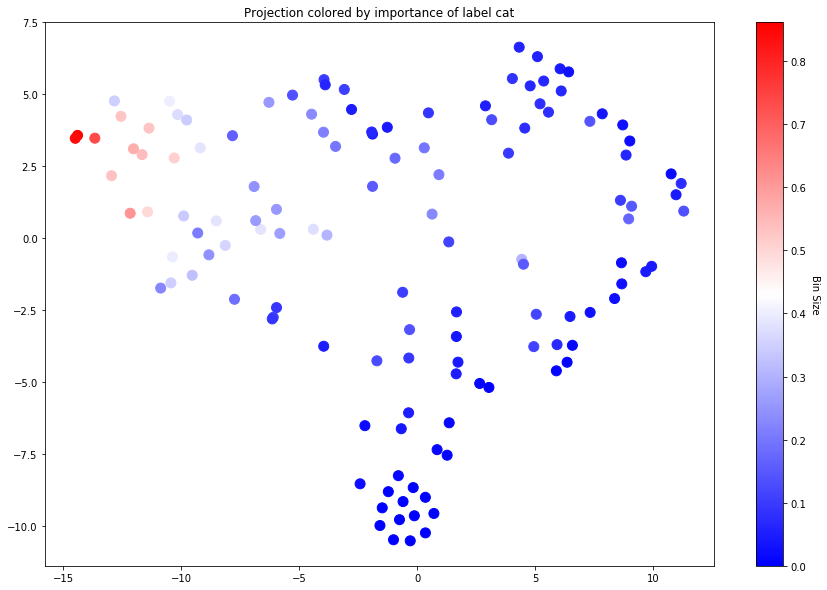

In [20]:
# Take into account only the importance of label 0.
l = 3
h = np.array(histograms)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l])
im = plt.scatter(lhp_data[:, 0], lhp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

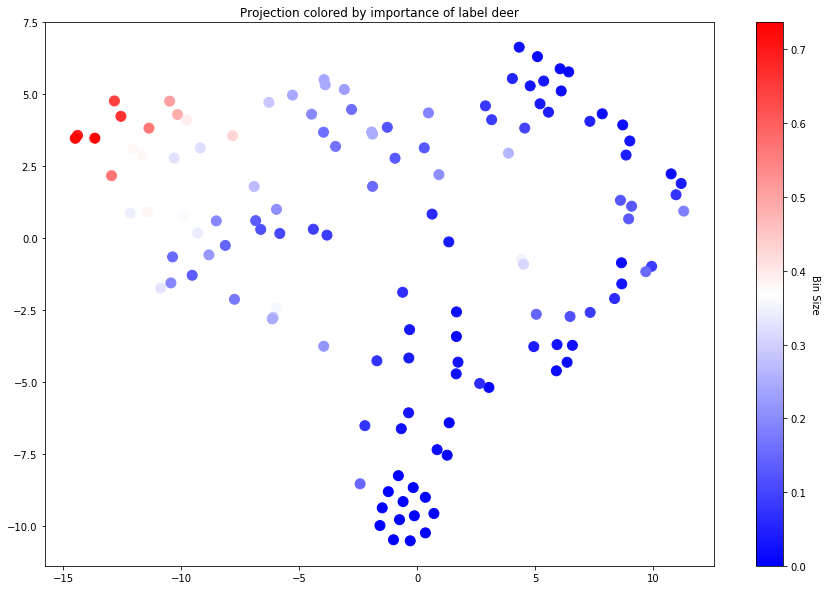

In [21]:
# Take into account only the importance of label 0.
l = 4
h = np.array(histograms)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l])
im = plt.scatter(lhp_data[:, 0], lhp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

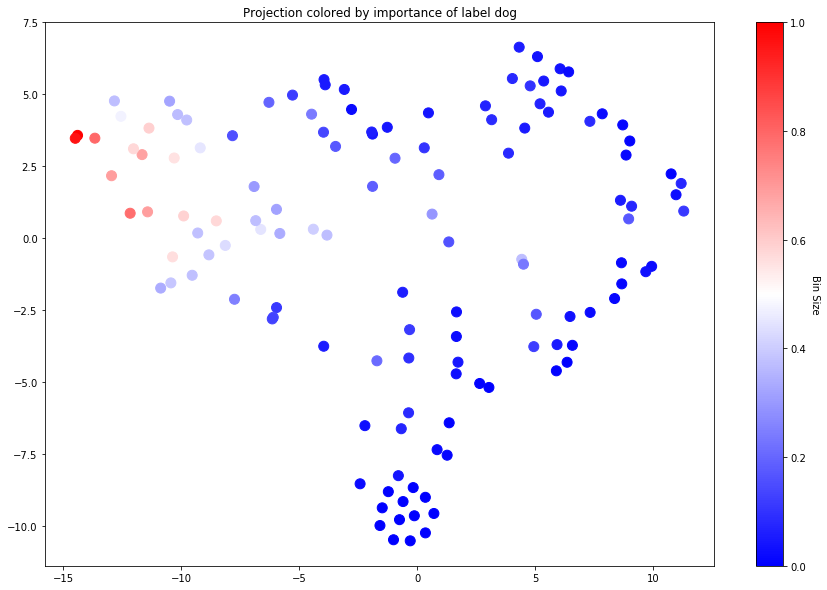

In [22]:
# Take into account only the importance of label 0.
l = 5
h = np.array(histograms)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l])
im = plt.scatter(lhp_data[:, 0], lhp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

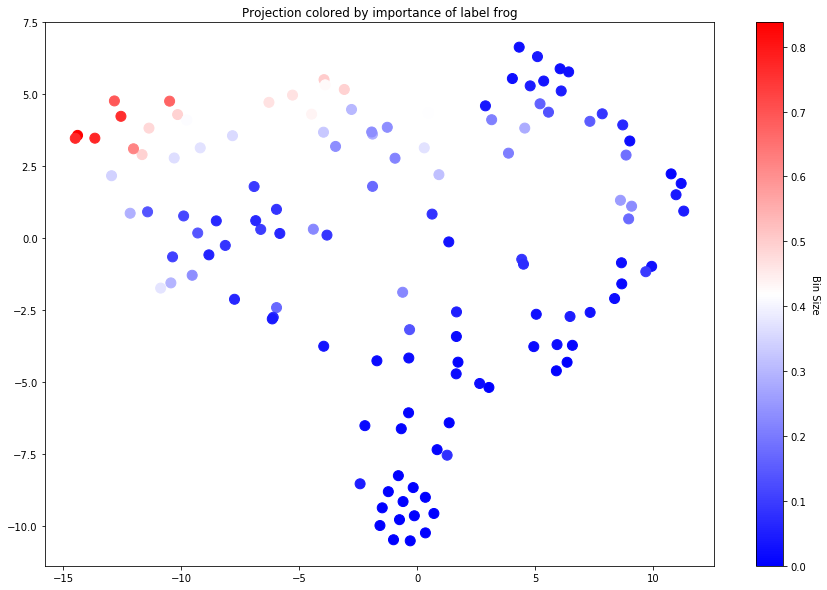

In [23]:
# Take into account only the importance of label 0.
l = 6
h = np.array(histograms)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l])
im = plt.scatter(lhp_data[:, 0], lhp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

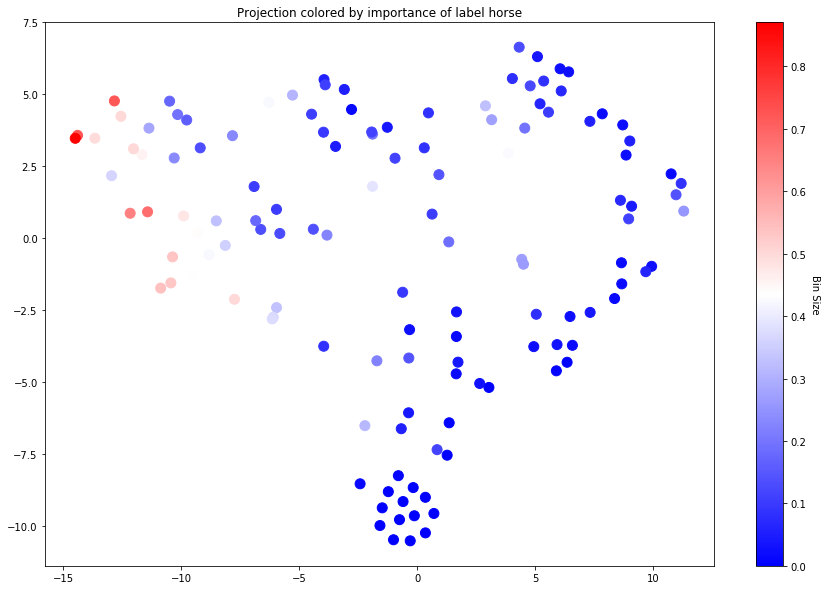

In [24]:
# Take into account only the importance of label 0.
l = 7
h = np.array(histograms)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l])
im = plt.scatter(lhp_data[:, 0], lhp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

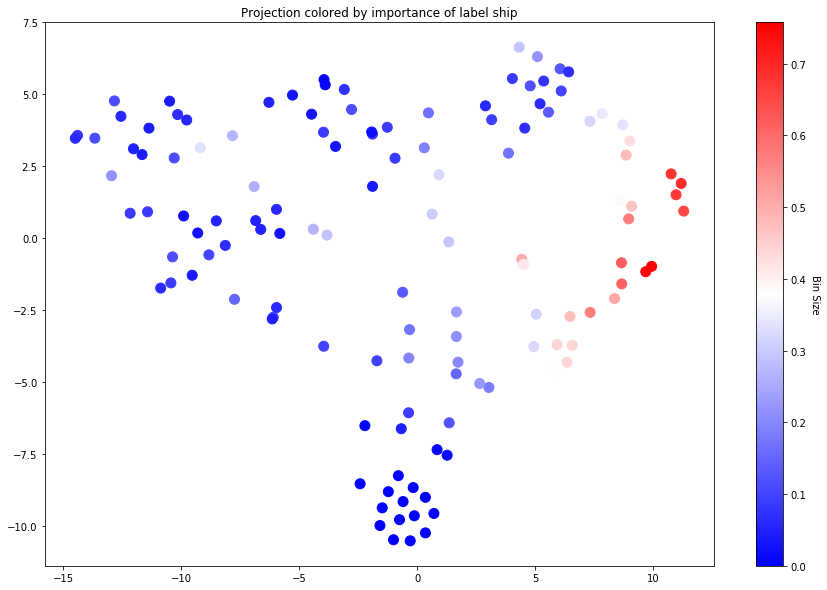

In [25]:
# Take into account only the importance of label 0.
l = 8
h = np.array(histograms)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l])
im = plt.scatter(lhp_data[:, 0], lhp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

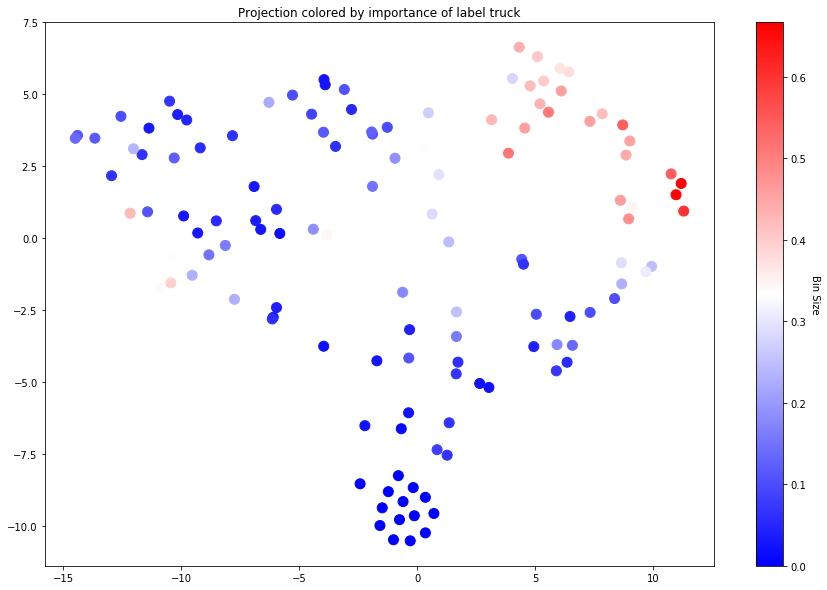

In [26]:
# Take into account only the importance of label 0.
l = 9
h = np.array(histograms)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l])
im = plt.scatter(lhp_data[:, 0], lhp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

Now, we are going to do the same analysis but only considering elements correctly classified.

In [41]:
# Build the histograms.
histograms_true = np.zeros((hidden_size, num_classes))

for u in range(hidden_size):
    for c in range(num_classes):
        a = activations[true_labels == pred_labels][true_labels[true_labels == pred_labels] == c, u]
        histograms_true[u, c] = np.sum(a)

# Normalize histograms.
histograms_true /= np.max(histograms_true)

# Sort the histogram rows
c = AgglomerativeClustering(n_clusters=histograms_true.shape[0]).fit(histograms_true)

merge_order = c.children_

index_list = [[i] for i in range(histograms_true.shape[0])]
for i, j in merge_order:
    index_list.append(index_list[i] + index_list[j])
order = index_list[-1]

histograms_true = histograms_true[order, :]
        
print(histograms_true.shape)

(128, 10)


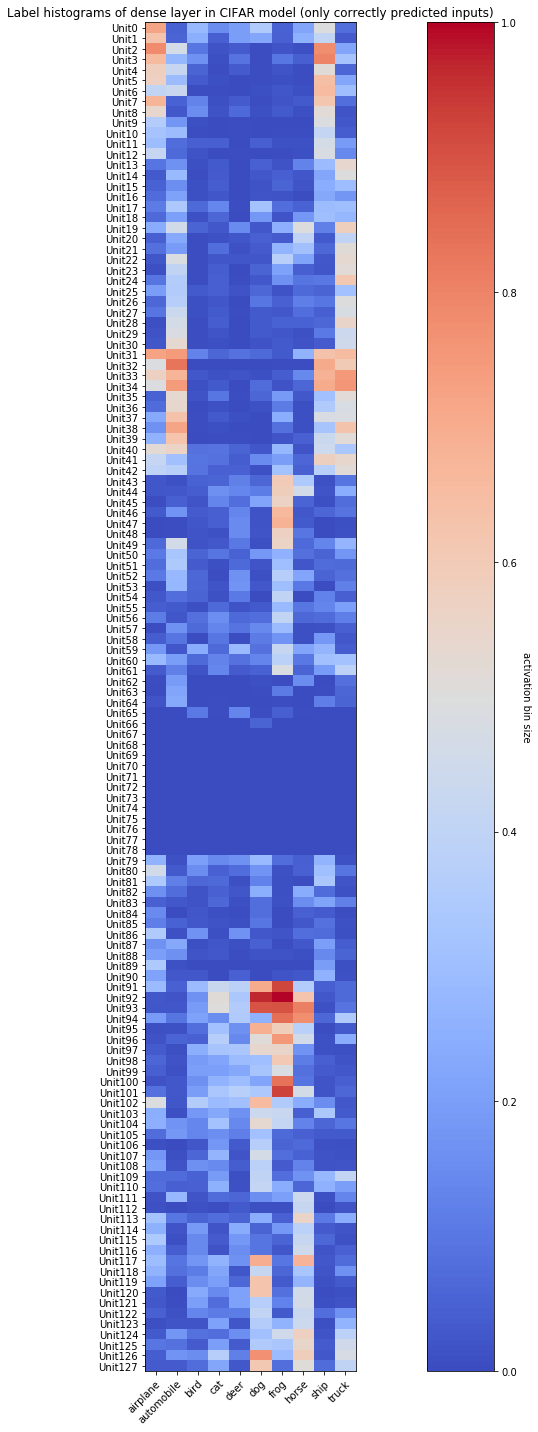

In [42]:
units = ["Unit" + str(i) for i in range(hidden_size)]

fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(histograms_true, aspect=0.5, cmap=cm.coolwarm)

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("activation bin size", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(units)))

ax.set_xticklabels(labels)
ax.set_yticklabels(units)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_title("Label histograms of dense layer in CIFAR model (only correctly predicted inputs)")

fig.tight_layout()
plt.show()

In [44]:
lht_projection = TSNE(n_components=2, perplexity=20, early_exaggeration=12.0, learning_rate=200.0).fit(histograms_true)

lhtp_data = lht_projection.embedding_

print(lhtp_data.shape, lht_projection.kl_divergence_)

(128, 2) 0.3957499563694


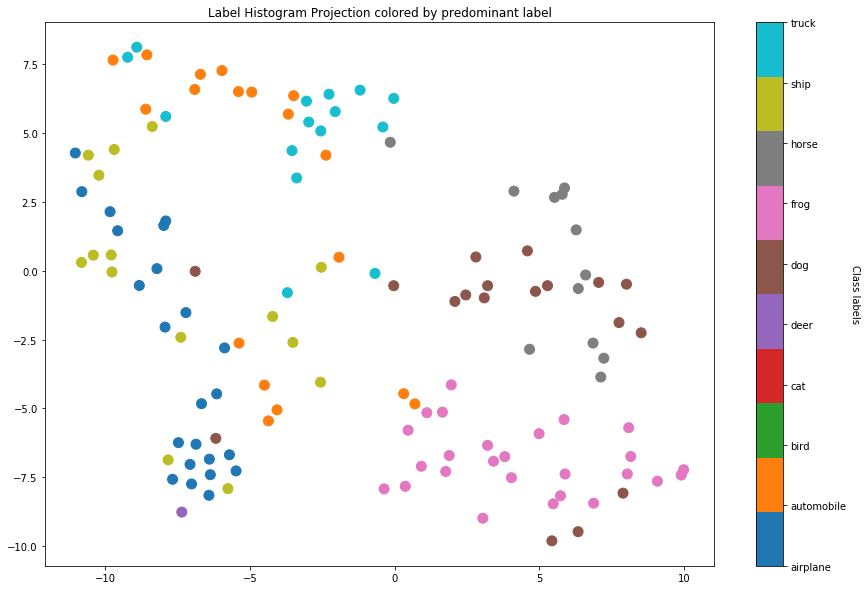

In [45]:
colors = np.argmax(histograms_true, axis=1)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Label Histogram Projection colored by predominant label")

im = plt.scatter(lhtp_data[:, 0], lhtp_data[:, 1], c=colors, cmap=cm.tab10, s=100)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Class labels", rotation=-90, va="bottom")
cbar.ax.set_yticklabels(labels)

plt.show()

Interesting notes:
    - No cat-predominat and bird-predominant units and only one deer-predominant unit.
    - Overlaps between airplane/ship, automobile/trucks, dogs/horse
    - Few overlaps for frogs (Frog was indeed the better classified class).

[Text(1,0,'airplane'),
 Text(1,0,'automobile'),
 Text(1,0,'bird'),
 Text(1,0,'cat'),
 Text(1,0,'deer'),
 Text(1,0,'dog'),
 Text(1,0,'frog'),
 Text(1,0,'horse'),
 Text(1,0,'ship'),
 Text(1,0,'truck')]

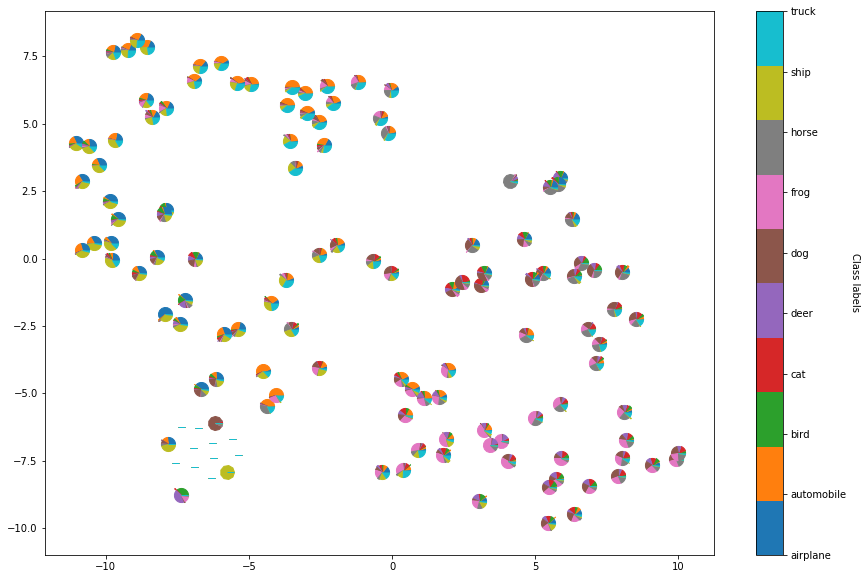

In [46]:
# Transform histogram data into pie chart.
h = np.array(histograms_true)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        h[i, :] /= t
    
    for j in range(1, h.shape[1]):
        h[i, j] += h[i, j-1]
        
fig, ax = plt.subplots(figsize=(15, 10))
        
# Plot piecharts.
for i in range(h.shape[0]):
    for j in range(h.shape[1]):
        if j == 0:
            a = 0
        else:
            a = 2*np.pi*h[i, j-1]
        
        b = 2*np.pi*h[i, j]
                
        x = [0] + np.cos(np.linspace(a, b, 10)).tolist()
        y = [0] + np.sin(np.linspace(a, b, 10)).tolist()
        xy = np.column_stack([x, y])
        
        ax.scatter(lhtp_data[i, 0], lhtp_data[i, 1], marker=(xy, 0), s=200, c=cm.tab10(j))

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Class labels", rotation=-90, va="bottom")
cbar.ax.set_yticklabels(labels)

Some interesting insights:
    - Cats mostly share predominance (in a smaller scale) with dogs and horses.
    - Bird-predominant units are hard to spot, only very few.
    - The deer-predominant unit interstingly has also a strong bird activation (could be the case of lack of features? Or lack of units?)
    - However, there is an interesting overlap between trucks and animal-classes.

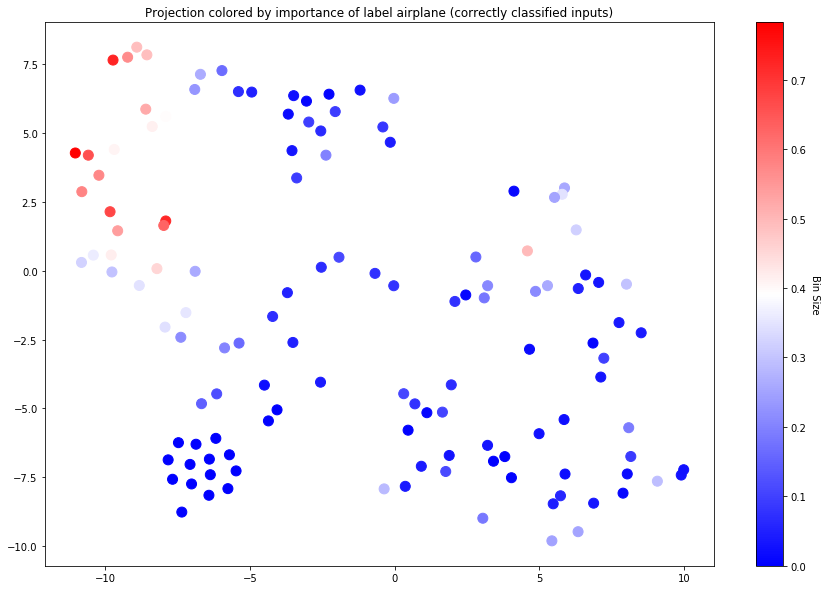

In [47]:
# Take into account only the importance of label 0.
l = 0
h = np.array(histograms_true)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l] + " (correctly classified inputs)")
im = plt.scatter(lhtp_data[:, 0], lhtp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

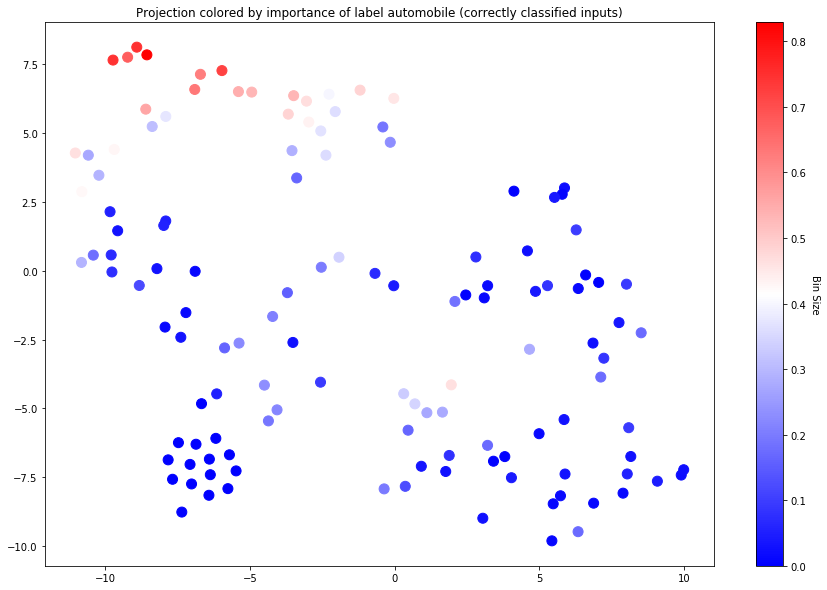

In [48]:
# Take into account only the importance of label 0.
l = 1
h = np.array(histograms_true)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l] + " (correctly classified inputs)")
im = plt.scatter(lhtp_data[:, 0], lhtp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

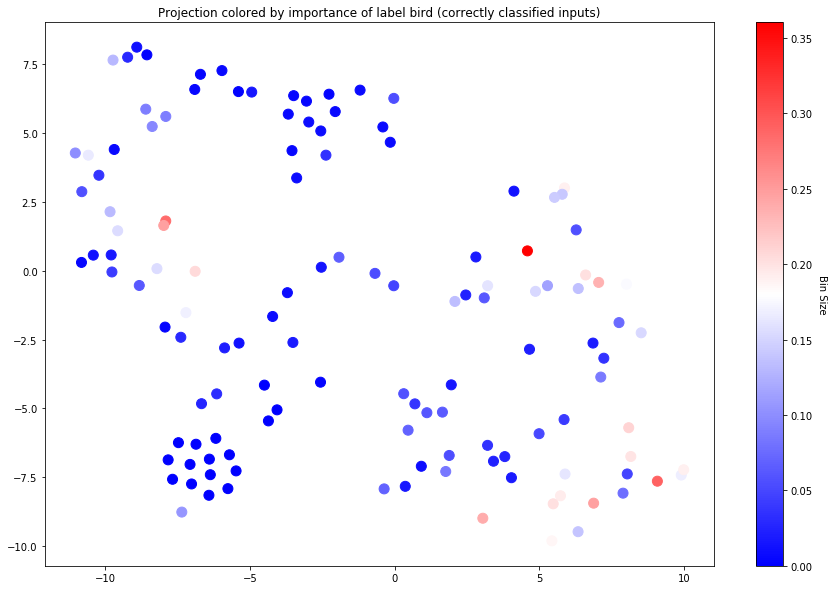

In [49]:
# Take into account only the importance of label 0.
l = 2
h = np.array(histograms_true)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l] + " (correctly classified inputs)")
im = plt.scatter(lhtp_data[:, 0], lhtp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

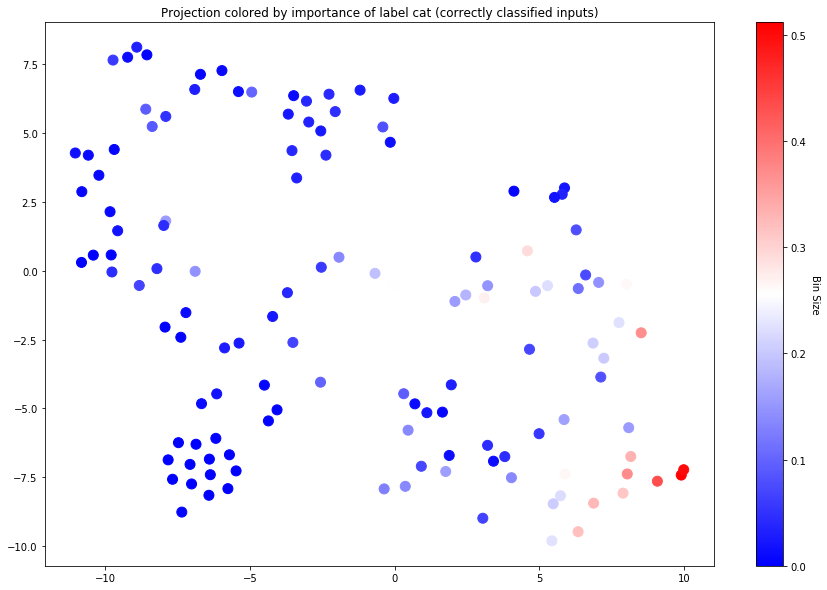

In [50]:
# Take into account only the importance of label 0.
l = 3
h = np.array(histograms_true)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l] + " (correctly classified inputs)")
im = plt.scatter(lhtp_data[:, 0], lhtp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

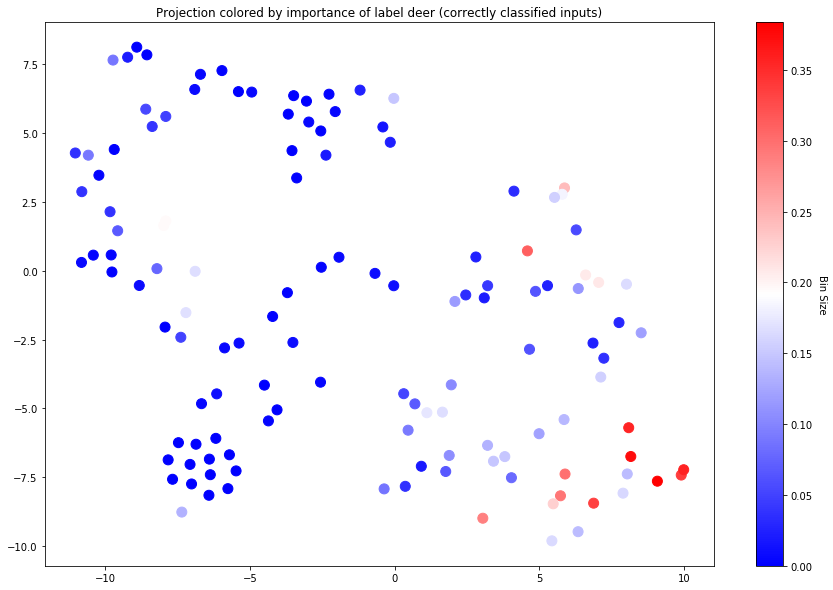

In [51]:
# Take into account only the importance of label 0.
l = 4
h = np.array(histograms_true)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l] + " (correctly classified inputs)")
im = plt.scatter(lhtp_data[:, 0], lhtp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

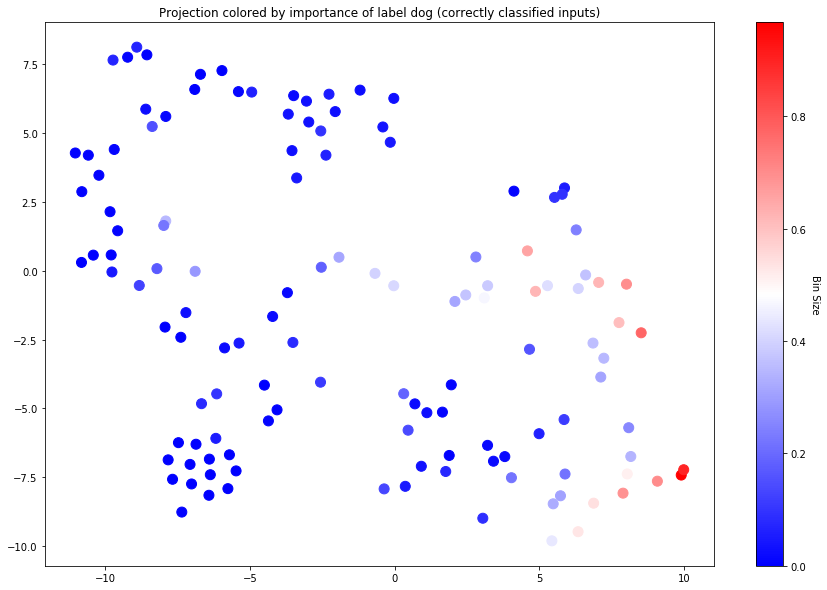

In [52]:
# Take into account only the importance of label 0.
l = 5
h = np.array(histograms_true)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l] + " (correctly classified inputs)")
im = plt.scatter(lhtp_data[:, 0], lhtp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

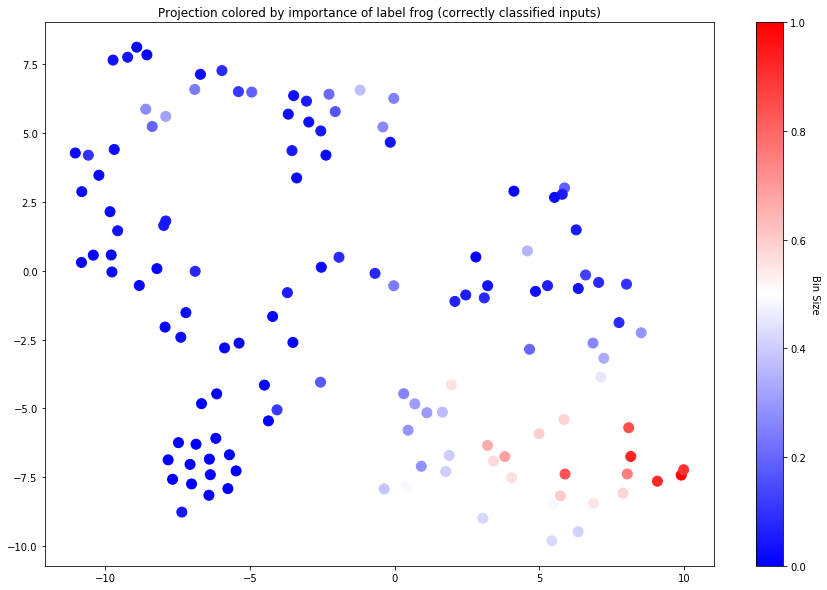

In [53]:
# Take into account only the importance of label 0.
l = 6
h = np.array(histograms_true)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l] + " (correctly classified inputs)")
im = plt.scatter(lhtp_data[:, 0], lhtp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

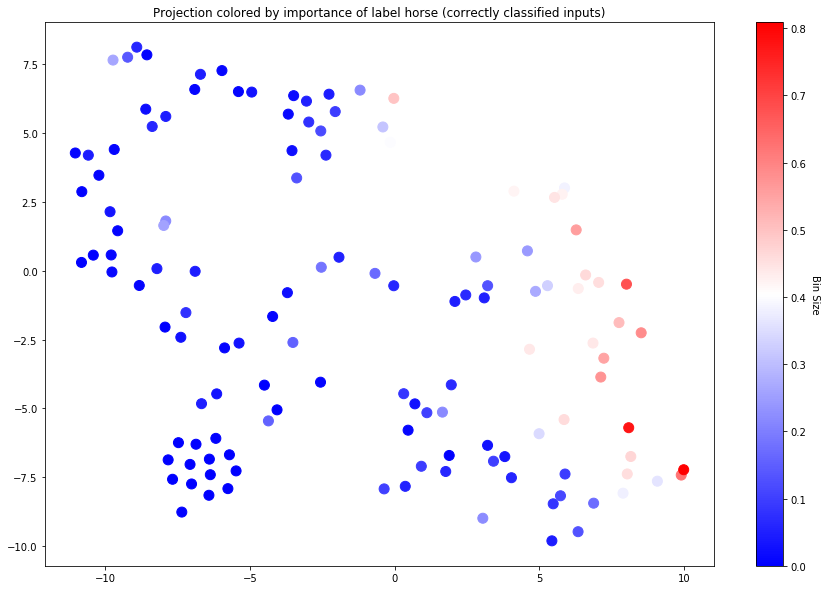

In [54]:
# Take into account only the importance of label 0.
l = 7
h = np.array(histograms_true)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l] + " (correctly classified inputs)")
im = plt.scatter(lhtp_data[:, 0], lhtp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

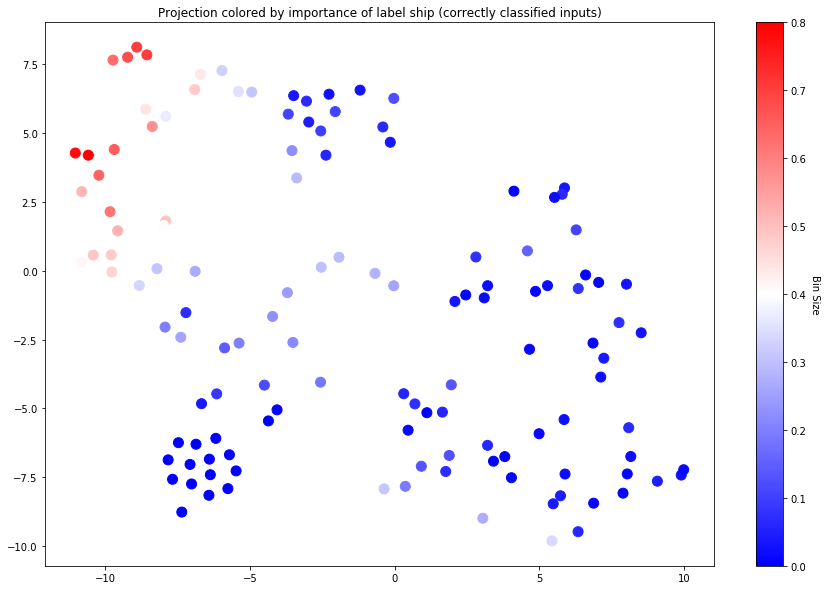

In [55]:
# Take into account only the importance of label 0.
l = 8
h = np.array(histograms_true)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l] + " (correctly classified inputs)")
im = plt.scatter(lhtp_data[:, 0], lhtp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()

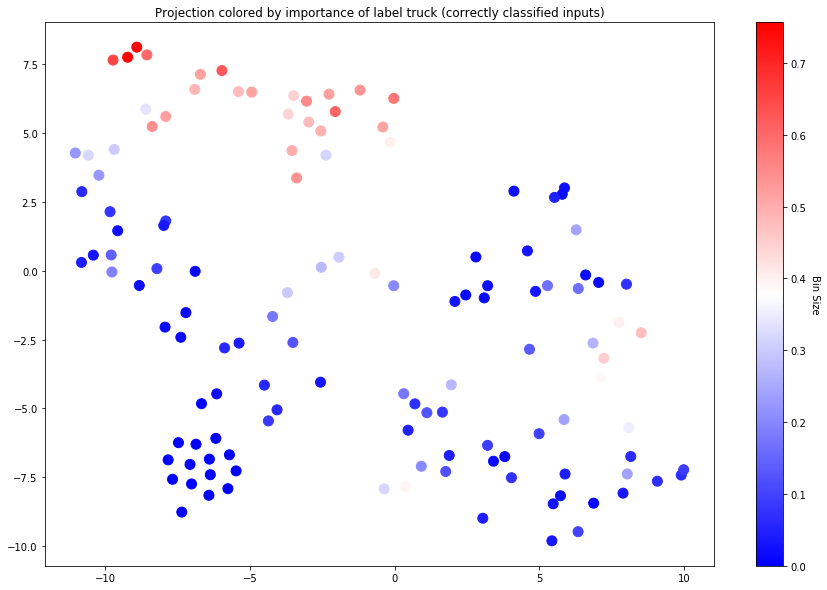

In [56]:
# Take into account only the importance of label 0.
l = 9
h = np.array(histograms_true)

# Divide every element of each row by the row's sum and calculate the accumulative value across the row.
colors = np.zeros((h.shape[0],))
for i in range(h.shape[0]):
    t = np.sum(h[i, :])
    
    if t > 0:
        colors[i] = h[i, l]

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Projection colored by importance of label " + labels[l] + " (correctly classified inputs)")
im = plt.scatter(lhtp_data[:, 0], lhtp_data[:, 1], c=colors, cmap=cm.bwr, s=100)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Bin Size", rotation=-90, va="bottom")
plt.show()